# Détectez les bad buzz grace au Deeplearning

In [1]:
import warnings
warnings.simplefilter(action='ignore')
# basic libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import unidecode
import gc
from io import StringIO
from timeit import default_timer as timer
# text preprocessing
import nltk
import gensim
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
# simple random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# deeplearning
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
# azure
import requests
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

trained = 1

done_preprocessing = 1

get_ready = 0

if not done_preprocessing:
    trained = 2

In [2]:
# nltk.download()

### Text preproccessing

On commence par tokéniser le texte (on ne garde que les mots, en supprimant la pontuation, les liens, les nombres ...).
On retire également les "stop-words", c'est-à-dire tous les articles, déterminants, pronoms et mots de liaison.

On trie le vocabulaire en utilisant comme référence les mots de l'embedding glove entraîné par l'Unversité de Stanford sur un dataset également issu de twitter. Ce traitement permet d'éliminer efficacement les twits pauvres, en se passant du moins possible de mots porteurs de sens.

On applique ensuite deux traitements différents séparément pour comparer leurs performances: la lemmatisation (qui garde seulement la forme canonique des mots, par exemple le féminin singulier) et le stemming (qui garde uniquement le radical des mots). 

In [3]:
test_size = 20000
val_size = 20000

small_features = 5000

max_words = 25

In [4]:
def load_embedding(filename):
    file = open(filename, encoding="utf8")
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

if not trained or not done_preprocessing or get_ready:
    raw_embedding = load_embedding("./models/glove.twitter.27B.100d.txt")

In [5]:
def clean_up(text):
        text = text.lower() # on retire les majuscules
        for exclude in ['&quot;', '&amp;']: # on retire les caractères spéciaux 
            text = text.replace(exclude, ' ')
        text = text.replace('-', '') # on unifie les mots séparés par des traits d'union
        text = text.split()
        for exclude in ['@', '/', 'www']: # on retire les liens et les utilisateurs identifiés
            text = [w for w in text if not exclude in w]
        text = ' '.join(text)
        text = unidecode.unidecode(text) # on retire les accents et les éventuels caractères étrangers
        # on tokenize le texte en supprimant les stop words
        # on ne garde que les mots appartenants au dictionnaire de l'embedding glove
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if not w in stop_words and w in raw_embedding]
        # on tronque les twits trop long
        if len(tokens) > max_words:
            tokens = tokens[:max_words]
        # on ne garde que les phrases de plus de 2 mots
        return ' '.join(tokens) if len(tokens) > 1 else ''

def update_target(tgt):
        return 1 if tgt else 0
    
def to_small_vocab(text):
    return " ".join([w for w in text.split()if w in small_vanilla_vectoriser.vocabulary_])

def stem(text):
    return " ".join([stemmer.stem(w) for w in text.split()])

def lem(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

if not done_preprocessing:
    train_df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    train_df = train_df[['target', 'text']]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stop_words = list(nltk.corpus.stopwords.words('english'))

    with open("./azure/sw.txt", 'w+') as f:
        for w in stop_words:
            f.write(w)
            f.write('\n')
    
    train_df["text"] = train_df["text"].apply(clean_up)
    
    train_df = train_df[train_df['text'] != ""]
    
    vanilla_vectoriser = CountVectorizer()
    vanilla_vectoriser.fit(train_df["text"].to_list())
    joblib.dump(vanilla_vectoriser, "./models/vanilla_vectoriser.joblib")
    
    small_vanilla_vectoriser = CountVectorizer(max_features=small_features)
    small_vanilla_vectoriser.fit(train_df["text"].to_list())
    joblib.dump(small_vanilla_vectoriser, "./models/small_vanilla_vectoriser.joblib")
    
    train_df["target"] = train_df["target"].apply(update_target)
    
    train_df = train_df.sample(frac=1)
    
    train_df.to_csv('./data/preprocessed.csv', index=False)

In [6]:
if not done_preprocessing:
    small_train_df = pd.read_csv('./data/preprocessed.csv')
    
    small_train_df["text"] = small_train_df["text"].apply(to_small_vocab)
    
    small_train_df = small_train_df[small_train_df["text"].apply(lambda x: x.count(" ") > 2)]
    
    stemmer = EnglishStemmer()
    lemmatizer = WordNetLemmatizer()

    small_train_df["text_stem"] = small_train_df["text"].apply(stem)

    small_train_df["text_lem"] = small_train_df["text"].apply(lem)
    
    small_stem_vectoriser = CountVectorizer(max_features=small_features)
    small_stem_vectoriser.fit(small_train_df["text_stem"].to_list())
    joblib.dump(small_stem_vectoriser, "./models/small_stem_vectoriser.joblib")

    small_lem_vectoriser = CountVectorizer(max_features=small_features)
    small_lem_vectoriser.fit(small_train_df["text_lem"].to_list())
    joblib.dump(small_lem_vectoriser, "./models/small_lem_vectoriser.joblib")
    
    # summary
    
    print(f"Found {len(vanilla_vectoriser.vocabulary_)} unique tokens in vanilla text")
    print(f"Final main dataframe size: {train_df.shape[0]}")
    print(f"Final small dataframe size: {small_train_df.shape[0]}")
    
    # make train test split
    small_test_df = small_train_df.head(test_size)
    small_train_df = small_train_df.tail(small_train_df.shape[0] - test_size)
    small_val_df = small_train_df.head(val_size)
    small_train_df = small_train_df.tail(small_train_df.shape[0] - val_size)
    small_test_df.to_csv('./data/small_text_test.csv', index=False)
    small_val_df.to_csv('./data/small_text_val.csv', index=False)
    small_train_df.to_csv('./data/small_text_train.csv', index=False)
    
    test_df = train_df.head(test_size)
    train_df = train_df.tail(train_df.shape[0] - test_size)
    val_df = train_df.head(val_size)
    train_df = train_df.tail(train_df.shape[0] - val_size)
    test_df.to_csv('./data/text_test.csv', index=False)
    val_df.to_csv('./data/text_val.csv', index=False)
    train_df.to_csv('./data/text_train.csv', index=False)


In [7]:
def save_vocabulary():
    with open("./azure/vocabulary.txt", 'w+') as f:
        vanilla_vectoriser = joblib.load("./models/vanilla_vectoriser.joblib")
        for w in vanilla_vectoriser.vocabulary_:
            f.write(w)
            f.write('\n')
                    
def load_voc():
    with open("./azure/vocabulary.txt", 'r') as f:
        lines = f.readlines()
    return [*map(lambda x: x[:-1], lines)]

if not done_preprocessing:            
    save_vocabulary()

In [8]:
train_df = pd.read_csv(f'./data/text_train.csv')
test_df = pd.read_csv(f'./data/text_test.csv')
val_df = pd.read_csv(f'./data/text_val.csv')
    
train_df.head()

,target,text
0,0,want go back work
1,1,changing headlights groceries cleaning house amazing roast dinner prep teaching fantastic saturday book
2,0,says find devout christians weird sorry
3,1,oooo pantesan huehehe ternyata lo ga di indo remembering pecel thing
4,1,give congratulations


In [9]:
small_train_df = pd.read_csv(f'./data/small_text_train.csv')
small_test_df = pd.read_csv(f'./data/small_text_test.csv')
small_val_df = pd.read_csv(f'./data/small_text_val.csv')
    
small_train_df.head()

,target,text,text_stem,text_lem
0,1,vs coming xbox live omfg nice,vs come xbox live omfg nice,v coming xbox live omfg nice
1,0,thanks tv meh lol seriously shouldnt watch,thank tv meh lol serious shouldnt watch,thanks tv meh lol seriously shouldnt watch
2,1,waiting hair dry make megan wish would already need daily dose hit list,wait hair dri make megan wish would alreadi need daili dose hit list,waiting hair dry make megan wish would already need daily dose hit list
3,1,lol haha know feel much going july needs asap friday finally,lol haha know feel much go juli need asap friday final,lol haha know feel much going july need asap friday finally
4,0,lisa wants say cares wants stay touch really doesnt luv us kidding talking,lisa want say care want stay touch realli doesnt luv us kid talk,lisa want say care want stay touch really doesnt luv u kidding talking


In [10]:
results_file = f'./results.csv'

if not os.path.isfile(results_file):
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'time', 'loss'])
    results.to_csv(results_file, index=False)

def add_result(name, accuracy, time, loss=None):
    result_df = pd.read_csv(results_file)
    result_df = result_df[result_df["model_name"] != name]
    result_df = result_df.append({"model_name": name, "accuracy": accuracy, "time": time, "loss": loss}, ignore_index=True)
    result_df.to_csv(results_file, index=False)
    
def get_results():
    result_df = pd.read_csv(results_file)
    print(result_df.head(20))

### Baseline

Le modèle de base servant de références aux autres modèles est une simple régression (random forest) appliquée sur les bag-of-words.

Comme la variable cible du jeu de données est balancée, on utilisera l'accuracy comme mesure de référence

In [11]:
opti = 0

n_rows_train = 100000

In [12]:
if not trained:
    small_vanilla_vectoriser = joblib.load("./models/small_vanilla_vectoriser.joblib")
    small_stem_vectoriser = joblib.load("./models/small_stem_vectoriser.joblib")
    small_lem_vectoriser = joblib.load("./models/small_lem_vectoriser.joblib")
    
    train_vectorized = small_vanilla_vectoriser.transform(small_train_df["text"].head(n_rows_train).to_list()).toarray()
    test_vectorized = small_vanilla_vectoriser.transform(small_test_df["text"].to_list()).toarray()
    val_vectorized = small_vanilla_vectoriser.transform(small_val_df["text"].to_list()).toarray()
    
    train_vectorized_stem = small_stem_vectoriser.transform(small_train_df["text_stem"].head(n_rows_train).to_list()).toarray()
    test_vectorized_stem = small_stem_vectoriser.transform(small_test_df["text_stem"].to_list()).toarray()
    val_vectorized_stem = small_stem_vectoriser.transform(small_val_df["text_stem"].to_list()).toarray()
    
    train_vectorized_lem = small_lem_vectoriser.transform(small_train_df["text_lem"].head(n_rows_train).to_list()).toarray()
    test_vectorized_lem = small_lem_vectoriser.transform(small_test_df["text_lem"].to_list()).toarray()
    val_vectorized_lem = small_lem_vectoriser.transform(small_val_df["text_lem"].to_list()).toarray()
    
    target = small_train_df["target"].head(n_rows_train).to_list()
    test_target = small_test_df["target"].to_list()

In [13]:
if opti:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc,
                               param_grid=param_grid,
                               cv=10, scoring="accuracy"
                               n_jobs=-1)
    forest_grid.fit(train_vectorized, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}
    
def train_rf(tr_dataset, te_dataset, name):
    t0 = timer()
    random_forest = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest.fit(tr_dataset, target)
    joblib.dump(random_forest, f"./models/{name}.joblib")
    
    perf = random_forest.score(te_dataset, test_target)
    t1 = timer() - t0
    
    add_result(name, perf, t1)
    
    del random_forest
    gc.collect()

#### Vanilla

In [14]:
if not trained:
    train_rf(train_vectorized, test_vectorized, "random_forest")

#### Avec stemming

In [15]:
if not trained:
    train_rf(train_vectorized_stem, test_vectorized_stem, "random_forest_stem")

#### Avec lemmatization

In [16]:
if not trained:
    train_rf(train_vectorized_lem, test_vectorized_lem, "random_forest_lem")

### Deeplearning

In [17]:
BUFFER_SIZE = 1000

AUTOTUNE = tf.data.AUTOTUNE

def process_model(model, hist, name, test_dataset, time):
    # get results
    history = pd.DataFrame(data=hist.history)
    model_performance = model.evaluate(test_dataset)
    # save results
    model.save(f"./models/{name}.h5")
    history.to_csv(f'./models/{name}_history.csv', index=False)
    model.save_weights(f'./models/{name}_weights.h5')
    add_result(name, model_performance[1], time, model_performance[0])


def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()
    
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#### Modèles simples

In [18]:
n_epochs = 20

batch_size = 16

data_passes = 1

steps_per_epoch = (train_df.shape[0] * data_passes) // (batch_size * n_epochs)

In [19]:
# get targets
y_train = np.asarray(small_train_df["target"].to_list())
y_test = np.asarray(small_test_df["target"].to_list())
y_val = np.asarray(small_val_df["target"].to_list())

In [20]:
def py_vectorize(txt):
    return vectorizer.transform([str(txt.numpy())]).toarray()[0]

def vectorize(txt, tgt):
    txt_vectorized = tf.py_function(py_vectorize, inp=[txt], Tout=[tf.int32])
    txt_vectorized = tf.convert_to_tensor(txt_vectorized[0], dtype=tf.int32)
    txt_vectorized.set_shape([input_dim])
    return txt_vectorized, tgt

def train_simple_nn(train_dataset, test_dataset, validation_dataset, name):
     # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(train_dataset), tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(test_dataset), tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((np.asarray(validation_dataset), tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.map(vectorize, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(vectorize, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.map(vectorize, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    # build model
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(10, input_dim=input_dim, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    
    # train model
    t0 = timer()
    
    print(model.summary())
    
    hist = model.fit(train_ds,
                     epochs=n_epochs,
                     verbose=2,
                     validation_data=val_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    t1 = timer() - t0
    process_model(model, hist, name, test_ds, t1)
    
    # cleaning
    del train_ds
    del test_ds
    del val_ds
    gc.collect()
    

##### Vanilla

In [21]:
model_name = "vanilla_nn"
if not trained:
    vectorizer = small_vanilla_vectoriser
    input_dim = len(vectorizer.vocabulary_)
    train_simple_nn(small_train_df["text"].to_list(),
                    small_test_df["text"].to_list(),
                    small_val_df["text"].to_list(),
                    model_name)

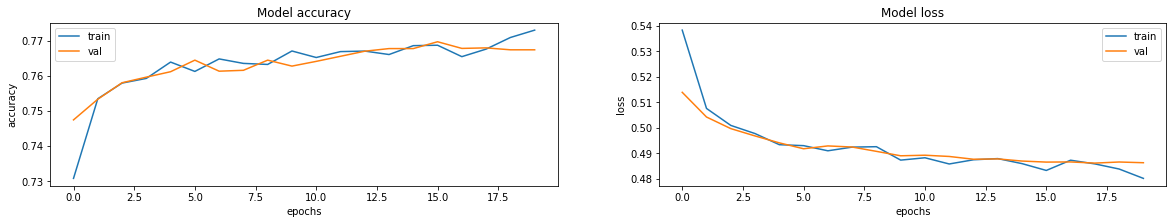

In [22]:
if trained==1:
    history = pd.read_csv(f'./models/{model_name}_history.csv')
    display_learning_curves(history)

##### Stemming

In [23]:
model_name = "stemming_nn"
if not trained:
    vectorizer = small_stem_vectoriser
    input_dim = len(vectorizer.vocabulary_)
    train_simple_nn(small_train_df["text_stem"].to_list(),
                    small_test_df["text_stem"].to_list(),
                    small_val_df["text_stem"].to_list(),
                    model_name)

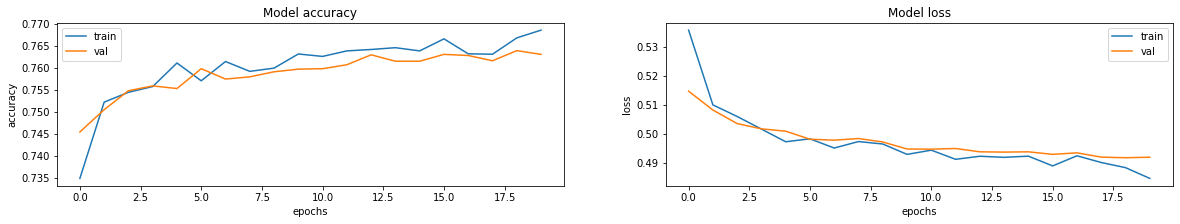

In [24]:
if trained==1:
    history = pd.read_csv(f'./models/{model_name}_history.csv')
    display_learning_curves(history)

##### Lemmatization

In [25]:
model_name = "lemmatization_nn"
if not trained:
    vectorizer = small_lem_vectoriser
    input_dim = len(vectorizer.vocabulary_)
    train_simple_nn(small_train_df["text_lem"].to_list(),
                    small_test_df["text_lem"].to_list(),
                    small_val_df["text_lem"].to_list(),
                    model_name)

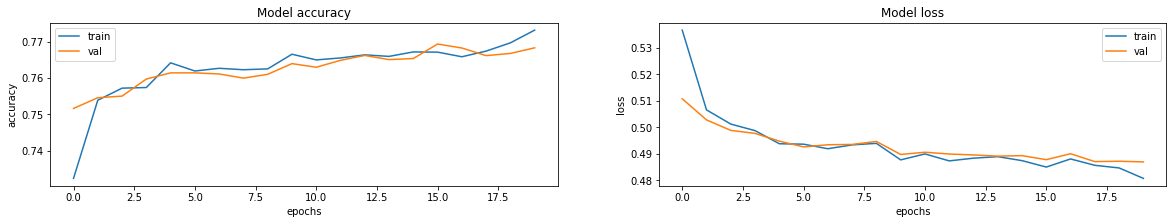

In [26]:
if trained==1:
    history = pd.read_csv(f'./models/{model_name}_history.csv')
    display_learning_curves(history)

#### Utilisation de modèles de plongement de mots

In [27]:
n_epochs = 20

batch_size = 64

data_passes = 2

steps_per_epoch = (train_df.shape[0] * data_passes) // (batch_size * n_epochs)

In [28]:
# get targets
y_train = np.asarray(train_df["target"].to_list())
y_test = np.asarray(test_df["target"].to_list())
y_val = np.asarray(val_df["target"].to_list())

In [29]:
if not trained or get_ready:
    X_train = train_df["text"].to_list()
    X_test = test_df["text"].to_list()
    X_val = val_df["text"].to_list()

    def encoder(data_train, data_test, data_val):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(data_train)
        encoded_train = tokenizer.texts_to_sequences(data_train)
        encoded_test = tokenizer.texts_to_sequences(data_test)
        encoded_val = tokenizer.texts_to_sequences(data_val)
        max_len = max([len(s.split()) for s in data_train])
        train_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=max_len, padding='post'))
        test_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=max_len, padding='post'))
        val_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_val, maxlen=max_len, padding='post'))

        return train_data, test_data, val_data, max_len, tokenizer

    X_train, X_test, X_val, vanilla_input_dim, vanilla_tokenizer = encoder(X_train, X_test, X_val)
    
    if not trained:
        joblib.dump(vanilla_tokenizer, "./azure/tokenizer.joblib")
      
    # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    
    print(f"Sequences encoded on {vanilla_input_dim} words")
    

Sequences encoded on 25 words


##### Glove

In [30]:
glove_dim = 100

In [31]:
def get_weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, glove_dim))
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

if not trained or get_ready:
    vocab_size = len(vanilla_tokenizer.word_index) + 1
    embedding_vectors = get_weight_matrix(raw_embedding, vanilla_tokenizer.word_index)
    embedding_layer = tf.keras.layers.Embedding(vocab_size, glove_dim, weights=[embedding_vectors], input_length=vanilla_input_dim, trainable=True)

In [32]:
model_name = "glove_cnn"

def create_glove_model(learning_rate=0.001):
    model = tf.keras.models.Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def optimize_glove_model():
    param_grid = dict(learning_rate=[
                         0.001,
                         0.0001,
                         0.00001,
                         tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-2,
                             decay_steps=10000,
                             decay_rate=0.9)])

    model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_glove_model,
                                                           epochs=2, batch_size=batch_size,
                                                           verbose=False)
    
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    with open("parameters.txt", 'w+') as f:
        s = str(grid_result.best_params_)
        print(s)
        f.write(s)
        
# optimize_glove_model()

In [33]:
def train_glove_model():
    lr = tf.keras.optimizers.schedules.ExponentialDecay(
             initial_learning_rate=1e-2,
             decay_steps=10000,
             decay_rate=0.9)
    
    glove_model = create_glove_model(lr)
    
    print(glove_model.summary())
    
    t0 = timer()
    hist = glove_model.fit(train_ds,
                           epochs=n_epochs,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    t1 = timer() - t0
    process_model(glove_model, hist, model_name, test_ds, t1)

if not trained:
    train_glove_model()

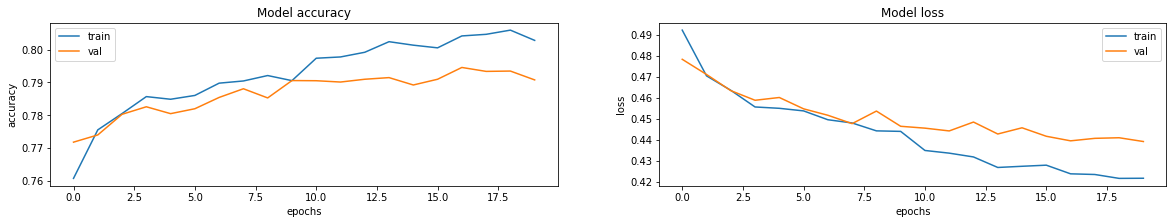

In [34]:
if trained==1 or get_ready:
    history = pd.read_csv(f'./models/{model_name}_history.csv')
    display_learning_curves(history)

##### Glove + LSTM

In [35]:
model_name = "glove_lstm_nn"

def train_glove_lstm_model():
    
    glove_model = tf.keras.models.Sequential()
    glove_model.add(embedding_layer) 
    glove_model.add(tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.2))
    glove_model.add(tf.keras.layers.GlobalMaxPooling1D())
    glove_model.add(tf.keras.layers.Dense(64,activation='relu')) 
    glove_model.add(tf.keras.layers.Dense(1,activation='sigmoid')) 

    print(glove_model.summary())
    lr = tf.keras.optimizers.schedules.ExponentialDecay(
             initial_learning_rate=1e-2,
             decay_steps=10000,
             decay_rate=0.9)
    
    glove_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
                        metrics=['accuracy'])
    t0 = timer()
    hist = glove_model.fit(train_ds,
                           epochs=n_epochs,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    t1 = timer() - t0
    process_model(glove_model, hist, model_name, test_ds, t1)


if not trained:
    train_glove_lstm_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           12545500  
_________________________________________________________________
lstm (LSTM)                  (None, 25, 128)           117248    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,671,069
Trainable params: 12,671,069
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2321/2321 - 18s - loss: 0.4887 - accuracy: 0.7639 - val_loss: 0.4697 - val_accuracy: 0.7740
Ep

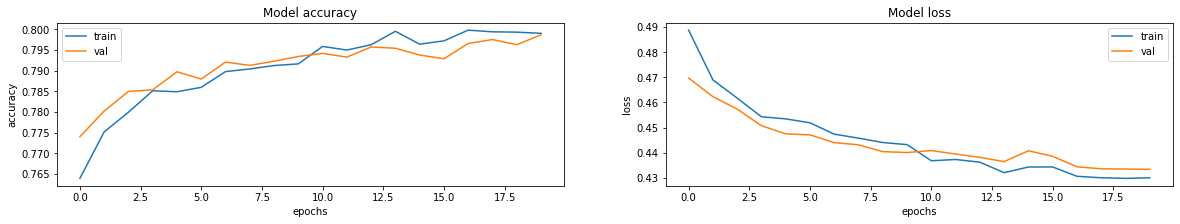

In [36]:
if trained==1:
    history = pd.read_csv(f'./models/{model_name}_history.csv')
    display_learning_curves(history)

### Azure

#### Requêtes au modèle déployé

In [ ]:
def parse_resp(rsp):
    return [float(r[1:-1])for r in rsp[1:-1].split(', ')]

headers = {'Content-Type': 'application/json'}

resp = requests.post(scoring_uri, input_data, headers=headers)

res_df["pred"] = parse_resp(resp.text)

res_df.head(10)

In [37]:
is_deployed = True

smpls = 20

def parse_resp(rsp):
    return [float(r[1:-1])for r in rsp[1:-1].split(', ')]

with open('./azure/azure_uri.txt', 'r') as f:
    scoring_uri = f.readline()

if is_deployed:
    
    res_df = pd.DataFrame()
    
    res_df["text"] = test_df["text"].head(smpls)
    
    res_df["target"] = test_df["target"].head(smpls)
    
    input_data = 'X'.join(res_df["text"].tolist())

    headers = {'Content-Type': 'application/json'}

    resp = requests.post(scoring_uri, input_data, headers=headers)

    res_df["pred"] = parse_resp(resp.text)

    res_df.to_csv("./azure/azure_pred.csv", index=False)
    
else:
    
    res_df = pd.read_csv("./azure/azure_pred.csv")

res_df.head(20)

,text,target,pred
0,nice deserve,1,0.965861
1,watching everybody loves raymond without princey,0,0.406926
2,looks like one wants play tonight might play alone horny tweets,0,0.232080
3,morning sowing seeds today finishing soaker talked lots interesting people yesterday blog,1,0.905198
4,would honored meet pug,1,0.905534
5,yeah give stuff slot tonight mix ill send u woot woot freestyles,1,0.862093
6,working today wedding tonight,0,0.596251
7,lost please help find good home,0,0.013232
8,gonzi ach well always hard court cheer,1,0.183508
9,waiting write ss exam next block,0,0.370721


#### Requêtes à l'API Cognitive Services Text Analytics

In [38]:
n_sample = 1000

with open(f'./azure/ASTA_key.txt', 'r') as f:
    key = f.readline()
        
with open(f'./azure/ASTA_endpoint.txt', 'r') as f:
    endpoint = f.readline()

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

if not trained:
    client = authenticate_client()

In [39]:
def sentiment_analysis_score(client, documents):
    pred_labels = []
    for response in client.analyze_sentiment(documents=documents):
        pos = response.confidence_scores.positive
        neg = response.confidence_scores.negative
        neu = response.confidence_scores.neutral
        s = pos + neg
        if s:
            pred_labels += [int(pos / s > .5)]
        else:
            pred_labels += [1]
    return pred_labels

In [40]:
if not trained:
    short_df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    short_df = short_df.sample(n=n_sample)
    short_df["target"] = short_df["target"].apply(update_target)
    docs = short_df["text"].tolist()
    lbls = short_df["target"].tolist()
    pred_lbls = []
    for i in range(10, n_sample + 1, 10):
        pred_lbls.extend(sentiment_analysis_score(client, docs[i-10:i]))
        
    add_result("ASTA", accuracy_score(lbls, pred_lbls), None)


### Display results

In [41]:
get_results()

            model_name  accuracy         time      loss
0   random_forest       0.74330   4673.442075 NaN      
1   random_forest_stem  0.74460   3145.852605 NaN      
2   random_forest_lem   0.74370   4217.279929 NaN      
3   vanilla_nn          0.76795   4371.061097  0.484366
4   stemming_nn         0.76415   3354.503793  0.491544
5   lemmatization_nn    0.76780   3995.933181  0.485960
6   glove_lstm_cnn      0.78160   814.337397   0.482108
7   w2v_lstm_nn         0.79690   611.238391   0.434156
8   ASTA                0.72100  NaN          NaN      
9   glove_cnn           0.79655   206.239439   0.436982
10  glove_lstm_nn       0.80350   289.738853   0.426784


### Error source

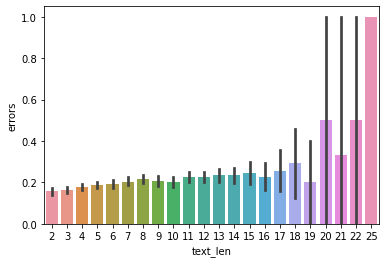

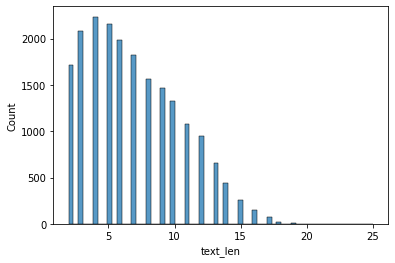

In [42]:
def corr_with_len(name):
    model = tf.keras.models.load_model(f"./models/{name}.h5")
    test_df["glove_lstm_pred"] = model.predict(test_ds)
    test_df["glove_lstm_pred"] = test_df["glove_lstm_pred"].apply(lambda x:int(x>.5))
    test_df["errors"] = test_df["target"] != test_df["glove_lstm_pred"]
    test_df["text_len"] = test_df["text"].apply(lambda x: x.count(" ") + 1)
    sns.barplot(x="text_len", y="errors", data=test_df)
    plt.show()
    sns.histplot(data=test_df["text_len"])
    plt.show()
    
model_name = "glove_lstm_nn"
corr_with_len(model_name)